In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm
import openai
from dotenv import load_dotenv
import os
import numpy as np
from sklearn.decomposition import PCA


load_dotenv()

EMBEDDING_MODEL = "text-embedding-ada-002"
COMPLETION_MODEL = "text-davinci-003"
openai.api_key = os.getenv('OPENAI_API_KEY')

## Scraping Mashable

The following section uses BeautifulSoup to scrape Mashable articles. Surprisingly, all but 2 articles still have live links as of 2023 (10 years after the original publication of the paper). There doesn't seem to be a rate limit, but we sleep after every second just to be safe. In total, scraping all ~ 39000 articles takes around 24 hours. Only run this once!

In [14]:
def get_page(url: str):
    page = requests.get(url)
    return BeautifulSoup(page.content, "html.parser")

def get_title(soup):
    return soup.find_all("h1", class_="mt-4 header-100 leading-tight max-w-5xl")[0].text

def get_article(soup):
    text = []
    article = soup.find("article")
    for p in article.find_all("p"):
        text.append(p.text)
    return ' '.join(text)

test_url = "http://mashable.com/2013/01/07/amazon-instant-video-browser/"
page = get_page(test_url)
get_title(page)

"Amazon's Streaming Video Library Now a Little Easier to Navigate"

In [15]:
get_article(page)

'Having trouble finding something to watch on Amazon Instant Video? The retailer launched Monday an experimental browsing tool(Opens in a new tab) that lets users discover movies and TV shows based on their genre preferences or simply the mood they\'re in. Movies and shows are divided up into categories, some of which bear the names of genres (i.e., "Comedy" and "Mystery/Thriller"), and others which are labeled by mood, such as "Feel-Good" and "Exciting." Users can toggle between TV shows and movies, and apply filters to show only videos that are available for free viewing to Prime subscribers, or ones that bear G or PG ratings. It\'s pretty basic, but it sure beats the haphazard organization of Amazon\'s current Instant Video(Opens in a new tab) page, which mixes rows of new releases with bestsellers and personal recommendations. The move is the latest in a series of investment\'s Amazon is making in its streaming video platform. Last week, the company inked a licensing agreement with

In [8]:
df = pd.read_csv('../data/OnlineNewsPopularity.csv')

In [ ]:
titles = []
articles = []

for i, url in tqdm(enumerate(df.url)):
    try:
        page = get_page(url)
        titles.append(get_title(page))
        articles.append(get_article(page))
        time.sleep(1)
    except:
        print("404")
        titles.append(None)
        articles.append(None)

In [47]:
text_df = pd.DataFrame({'titles': titles, 'articles': articles})
text_df.to_csv('../data/mashable_texts.csv')

## Load Scraped Data and Get Embeddings

In [118]:
text_df = pd.read_csv('../data/mashable_texts.csv')
text_df

,titles,articles,truncated_articles
0,Amazon's Streaming Video Library Now a Little ...,Having trouble finding something to watch on A...,Having trouble finding something to watch on A...
1,AP's Twitter to Begin Displaying Sponsored Tweets,The Associated Press is the latest news organi...,The Associated Press is the latest news organi...
2,Apple's App Store Passes 40 Billion Downloads,It looks like 2012 was a pretty good year for ...,It looks like 2012 was a pretty good year for ...
3,This Astronaut Is Rooting for Notre Dame Tonight,"When it comes to college football, NASA astron...","When it comes to college football, NASA astron..."
4,New U-Verse Apps Simplify Sharing Photos and V...,LAS VEGAS -- Sharing photos and videos on your...,LAS VEGAS -- Sharing photos and videos on your...
...,...,...,...
39639,Samsung app aims to improve autistic children'...,While some believe smartphones and tablets may...,While some believe smartphones and tablets may...
39640,"Seth Rogen, James Franco are planning to live-...",LOS ANGELES -- Call it their exit Interview. J...,LOS ANGELES -- Call it their exit Interview. J...
39641,App developer says 'Merry Christmas' by paying...,"Nothing says ""Merry Christmas"" like never havi...","Nothing says ""Merry Christmas"" like never havi..."
39642,Two dead after Ukraine rocked by series of blasts,Ukrainians were on high alert on Saturday afte...,Ukrainians were on high alert on Saturday afte...


In [85]:
def get_embedding(text: list[str], model: str=EMBEDDING_MODEL) -> np.array:
    result = openai.Embedding.create(
      model=model,
      input=text
    )
    return np.array([e['embedding'] for e in result['data']])

In [86]:
# fill NA with non-empty string so that it's a valid input for the Embedding API (since there are only 2, it's much easier to embed them than remove them / keep track of indices)

text_df.fillna('test', inplace=True)

In [134]:
embeds = []

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

for chunk in chunker(list(text_df.titles), 1000):
    embed = get_embedding(chunk)
    embeds.append(embed)
    time.sleep(1)

In [135]:
title_embeds = np.concatenate(embeds)
title_embeds.shape

(39644, 1536)

In [103]:
text_df['truncated_articles'] = text_df.articles.apply(lambda x: ' '.join(x.split(' ')[:100]))

In [104]:
df.shape

(39644, 61)

In [122]:
temp_embeds = []

for chunk in chunker(list(text_df.truncated_articles), 50):
    embed = get_embedding(chunk)
    temp_embeds.append(embed)
    time.sleep(1)

In [123]:
article_embeds = np.concatenate(temp_embeds)
article_embeds.shape

(39644, 1536)

In [125]:
articles = pd.DataFrame(article_embeds)
articles.columns = [f'article_{i}' for i in articles.columns]
articles.head()

,article_0,article_1,article_2,article_3,article_4,article_5,article_6,article_7,article_8,article_9,...,article_1526,article_1527,article_1528,article_1529,article_1530,article_1531,article_1532,article_1533,article_1534,article_1535
0,-0.012208,-0.032979,-0.002669,-0.047079,-0.025611,0.023487,-0.018800,-0.037281,-0.012208,-0.022079,...,0.018959,-0.000337,0.003880,-0.011650,-0.022597,0.006081,0.010847,0.009460,-0.009825,-0.022159
1,-0.013808,0.000765,0.013664,-0.019775,-0.022122,0.005268,-0.021112,0.006311,-0.003980,-0.017270,...,0.009055,0.012366,0.036323,-0.007278,-0.021833,0.002931,0.021020,-0.004347,-0.014228,0.000283
2,-0.015229,-0.006807,0.009379,-0.016492,0.001912,-0.021234,-0.014668,-0.002931,0.015502,-0.029285,...,-0.010975,-0.024426,0.010181,-0.017573,-0.015919,-0.000314,0.005559,-0.011985,0.011522,0.003040
3,0.005463,-0.019334,-0.000850,-0.013948,-0.022979,-0.000360,-0.041616,-0.005637,-0.012957,0.001277,...,0.010170,-0.019736,0.023876,-0.026221,-0.002728,0.011791,-0.002196,-0.020567,-0.013164,-0.015234
4,-0.010165,-0.019630,0.016818,-0.022939,-0.007622,0.010313,-0.022280,-0.024312,-0.006670,-0.034389,...,-0.002807,-0.001695,0.009203,-0.013898,-0.002001,0.030406,-0.014248,0.009795,-0.002094,-0.008604


In [136]:
titles = pd.DataFrame(title_embeds)
titles.columns = [f'title_{i}' for i in titles.columns]
titles.head()

,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,...,title_1526,title_1527,title_1528,title_1529,title_1530,title_1531,title_1532,title_1533,title_1534,title_1535
0,-0.007851,-0.007891,0.007091,-0.040502,-0.001858,0.026588,-0.001136,-0.042530,-0.008771,-0.024173,...,0.007738,-0.008358,0.007811,-0.011513,-0.017610,0.016116,-0.018557,-0.006267,-0.013474,-0.004606
1,-0.018165,-0.008373,-0.004793,-0.022743,-0.016029,0.007358,-0.014450,-0.003319,-0.000923,-0.022597,...,0.016918,-0.017688,0.029166,-0.018922,-0.017860,0.019970,-0.005663,-0.006751,-0.001578,-0.023274
2,-0.016793,-0.011971,0.006296,-0.014923,-0.005274,0.001387,-0.028270,-0.024369,0.021469,-0.034308,...,0.006313,-0.005802,0.009606,-0.013828,-0.012365,0.016647,0.010534,-0.011269,0.014496,-0.002233
3,-0.005299,-0.017810,0.005114,-0.015840,-0.008151,-0.003208,-0.012535,-0.008826,-0.014478,0.005924,...,0.013242,-0.022121,0.023205,-0.020878,-0.001485,0.043633,-0.004532,-0.010769,-0.000471,-0.009024
4,-0.002030,0.003554,0.026681,-0.023280,-0.002511,0.006581,-0.021074,-0.031252,0.008278,-0.023758,...,0.007946,0.002985,0.004797,-0.026522,0.003717,0.032448,-0.007707,0.002254,0.009102,-0.007222


In [139]:
pd.concat([text_df, titles, articles], axis=1).to_csv('../data/text_with_embeddings.csv', index=False)

## EDA

In [5]:
embed_df = pd.read_csv('../data/text_with_embeddings.csv')

In [9]:
TITLES = [col for col in embed_df if 'title' in col]

In [13]:
titles = embed_df[TITLES]
titles.drop(['titles'], axis=1, inplace=True)
titles.shape

/var/folders/lr/597pxhmx2z78r4vysc_dvsth0000gn/T/ipykernel_47286/1126482350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titles.drop(['titles'], axis=1, inplace=True)


(39644, 1536)

In [15]:
titles_pca = PCA(n_components=3)
small_titles = titles_pca.fit_transform(titles.iloc[:1000])

small_titles

array([[-0.09445938,  0.02458537, -0.01800454],
       [ 0.00550876,  0.13179702, -0.10425545],
       [-0.11300009,  0.06916068, -0.05797902],
       ...,
       [ 0.12892649, -0.10859281,  0.03392225],
       [-0.02117105, -0.04043542, -0.00304175],
       [-0.08243222, -0.06343013, -0.02188566]])

In [17]:
vis_df_pca = pd.DataFrame({'x': small_titles[:,0], 'y': small_titles[:,1], 'z': small_titles[:,2], 'shares': df.iloc[:1000][' shares']})
vis_df_pca

,x,y,z,shares
0,-0.094459,0.024585,-0.018005,593
1,0.005509,0.131797,-0.104255,711
2,-0.113000,0.069161,-0.057979,1500
3,0.099219,-0.128088,-0.021188,1200
4,-0.132162,0.017480,-0.010688,505
...,...,...,...,...
995,-0.062434,0.189378,-0.034478,785
996,-0.005649,0.077710,-0.000534,2400
997,0.128926,-0.108593,0.033922,2300
998,-0.021171,-0.040435,-0.003042,5200


In [23]:
import umap

reducer = umap.UMAP(n_components=3)

small_titles = reducer.fit_transform(titles.iloc[:1000])

In [24]:
vis_df_pca = pd.DataFrame({'x': small_titles[:,0], 'y': small_titles[:,1], 'z': small_titles[:,2], 'shares': df.iloc[:1000][' shares']})
vis_df_pca

,x,y,z,shares
0,9.554237,-1.278255,3.465808,593
1,8.811398,-0.220465,2.863716,711
2,10.638893,-1.395323,3.299628,1500
3,6.844205,-1.813968,5.112868,1200
4,9.371452,-1.294995,3.281158,505
...,...,...,...,...
995,9.720406,-0.354526,3.450518,785
996,8.787274,-0.447008,2.762418,2400
997,6.875944,0.334024,3.688497,2300
998,9.132878,-2.490519,2.895608,5200


In [25]:
import plotly.express as px

px.scatter_3d(vis_df_pca, x='x', y='y', z='z', color='shares')

In [149]:
df['class'] = df[' shares'].apply(lambda x: 1 if x > 1400 else 0)
df['class'].value_counts()

0    20082
1    19562
Name: class, dtype: int64

In [156]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [166]:
original_feats = df.iloc[:10000].drop(['url', ' timedelta', ' shares', 'class'], axis=1).values
y_train = df.iloc[:10000]['class'].values

In [164]:
X_test = df.iloc[10000: 11000].drop(['url', ' timedelta', ' shares', 'class'], axis=1).values
y_test = df.iloc[10000: 11000]['class'].values

In [169]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()

clf.fit(original_feats, y_train)
accuracy_score(y_test, clf.predict(X_test))

/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.608

In [198]:
article_pca = PCA(n_components=50)
small_article = article_pca.fit_transform(articles.iloc[:10000])

titles_pca = PCA(n_components=50)
small_titles = titles_pca.fit_transform(titles.iloc[:10000])

In [197]:
article_pca.explained_variance_ratio_.sum()

0.17942964582075385

In [190]:
pca_feats = np.concatenate([df.drop(['url', ' timedelta', ' shares', 'class'], axis=1).values[:10000], small_article, small_titles], axis=1)
pca_feats.shape

(10000, 78)

In [191]:
original_feats.shape

(10000, 58)

In [193]:
a_test = article_pca.transform(articles.iloc[10000:11000])
t_test = titles_pca.transform(titles.iloc[10000:11000])

X_test_pca = np.concatenate([df.drop(['url', ' timedelta', ' shares', 'class'], axis=1).values[10000:11000], a_test, t_test], axis=1)
X_test_pca.shape

(1000, 78)

In [171]:
big_feats_df = pd.concat([df.drop(['url', ' timedelta', ' shares', 'class'], axis=1), titles, articles], axis=1)

In [172]:
big_feats = big_feats_df.iloc[:10000].values
X_test_big = big_feats_df.iloc[10000:11000].values

In [ ]:
pca = PCA(n_components=3)
vis_pca = pca.fit_transform(df[NUMERIC_COLS].values)

In [173]:
clf = LogisticRegression()

clf.fit(big_feats, y_train)
accuracy_score(y_test, clf.predict(X_test_big))

/Users/bryanwang/opt/miniconda3/envs/stat-222/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.608

In [196]:
clf = RandomForestClassifier()
clf.fit(small_titles, y_train)
accuracy_score(y_test, clf.predict(t_test))

0.51

In [176]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(original_feats, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.674

In [ ]:
import numpy as np
import statsmodels.api as sm
import pandas as pd

# Generate some sample data


# Fit a negative binomial GLM with log link function
model = sm.GLM(original_feats, sm.add_constant(data['x']), family=sm.families.NegativeBinomial(alpha=1.5), link=sm.genmod.families.links.log)
result = model.fit()

# Print the model summary
print(result.summary())

In [195]:
clf = RandomForestClassifier()
clf.fit(pca_feats, y_train)
accuracy_score(y_test, clf.predict(X_test_pca))

0.62

In [181]:
import xgboost as xgb

clf = xgb.XGBClassifier()
clf.fit(original_feats, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.629

In [182]:
clf = xgb.XGBClassifier()
clf.fit(big_feats, y_train)
accuracy_score(y_test, clf.predict(X_test_big))

0.604

In [194]:
clf = xgb.XGBClassifier()
clf.fit(pca_feats, y_train)
accuracy_score(y_test, clf.predict(X_test_pca))

0.614

In [29]:
np.mean(df[' shares']), np.var(df[' shares'])

(3395.3801836343455, 135182573.71299252)

<AxesSubplot: ylabel='Frequency'>

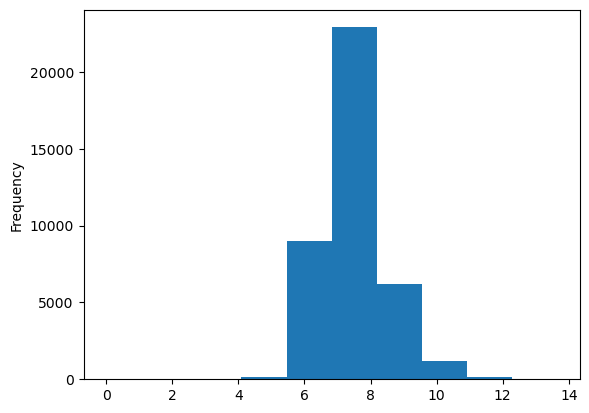

In [45]:
np.log(df[' shares']).plot(kind='hist')

In [41]:
df[df[' shares'] == 0]

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares


In [36]:
df[df[' shares'] < 100000][' shares'].var()

35892878.040344484

In [46]:
np.log(df[' shares']).mean(), np.log(df[' shares']).var()

(7.4748549241986275, 0.8658043625137046)

In [55]:
df[df[' shares'] < 1]

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares


In [53]:
df.shape

(39644, 61)